# Stochastic Volatility

In [Part I](bayesian_regression.ipynb), we looked at how to perform inference on a simple Bayesian linear regression model using SVI.  In this tutorial, we'll explore more expressive guides as well as exact inference techniques.  We'll use the same dataset as before.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.distributions import constraints

import pyro
import pyro.distributions as dist
from pyro.infer.autoguide import AutoDelta, AutoMultivariateNormal
from pyro.infer import SVI, Trace_ELBO
from pyro.optim import Adam

pyro.set_rng_seed(1)
assert pyro.__version__.startswith('0.4.1')

In [ ]:
def hmm_model(data):
    """
    y = diag(exp(h_t / 2)) * eps_t
    eps ~ Q L_eps rho_t
    h_{i+1} = mu + Phi(h_t - mu) + eta

    We do this in log space to convert multiplicative noise to additive noise
    so we can leverage the GaussianHMM distribution.

    log y_kt = h_kt / 2 + log <L_eps, delta_t>
            ~= h_kt / 2 + gamma_kt where gamma ~ MVN(0. sigma)
    and we moment match to compute epsilon.

    :param data: Tensor of the shape ``(batch, timesteps, returns)``
    :type data: torch.Tensor
    :returns distribution: posterior distribution over states given data
    """
    # TODO put priors over the parms here
    state_dim = data.shape[-1]
    with pyro.plate(len(data)):
        mu = pyro.param('mu', torch.zeros(state_dim))
        L = pyro.param('L', 0.1 * torch.eye(state_dim), constraint=constraints.lower_cholesky)
        init_dist = dist.MultivariateNormal(mu, scale_tril=L)

        L_eta = pyro.param('L_eta', 0.4 * torch.eye(state_dim), constraint=constraints.lower_cholesky)
        mu_eta = torch.zeros(state_dim)
        trans_matrix = pyro.param('phi', 0.5 * torch.ones(state_dim))
        # this gives us a zero matrix with phi on the diagonal
        trans_matrix = trans_matrix.diag_embed()
        trans_dist = dist.MultivariateNormal(mu_eta, scale_tril=L_eta)

        mu_gamma = pyro.param('mu_gamma', torch.zeros(state_dim))
        L_gamma = pyro.param('L_gamma', 0.5 * torch.eye(state_dim), constraint=constraints.lower_cholesky)
        obs_matrix = torch.eye(state_dim, state_dim)
        # latent state is h_t - mu
        obs_dist = dist.MultivariateNormal(-mu_gamma, scale_tril=L_gamma)

        hmm_dist = dist.GaussianHMM(init_dist, trans_matrix, trans_dist, obs_matrix, obs_dist)
        pyro.sample('obs', hmm_dist, obs=data)

In [2]:
def sequential_model(num_samples=10, timesteps=500, state_dim=2, init_dist=None):
    """
    Generate data of shape: (samples, timesteps, state_dim)
    where the generative model is defined by:
        y = exp(h/2) * eps
        h_{t+1} = mu + Phi (h_t - mu) + eta_t
    where eps and eta are sampled iid from a MVN distribution
    """
    ys = []
    mu_trans = torch.zeros(state_dim)
    cov_trans = pyro.param('L_eta', 0.2 * torch.eye(state_dim, state_dim))
    mu_obs = pyro.param('mu_gamma', torch.zeros(state_dim))
    cov_obs = pyro.param('L_gamma', 0.2 * torch.eye(state_dim, state_dim))
    transition = pyro.param('phi', 0.2 * torch.randn(state_dim))
    # this is to generate data as the way model 2 does
    # we would use the entire transition matrix for model 3
    with pyro.plate('samples', num_samples):
        transition = transition.diag_embed()
        trans_dist = dist.MultivariateNormal(mu_trans, scale_tril=cov_trans)
        obs_dist = dist.MultivariateNormal(mu_obs, scale_tril=cov_obs)
    obs = torch.eye(state_dim, state_dim)
    if init_dist is None:
        z = torch.zeros(num_samples, state_dim)
    else:
        z = pyro.sample('z_0', init_dist)

    for i in range(timesteps):
        trans_noise = pyro.sample('trans_noise', trans_dist)
        z = z.unsqueeze(1).bmm(transition).squeeze(1) + trans_noise
        # add observation noise
        obs_noise = pyro.sample('obs_noise', obs_dist)
        y = z @ obs + obs_noise
        ys.append(y)
    data = torch.stack(ys, 1)
    assert data.shape == (num_samples, timesteps, state_dim)
    return data

In [ ]:
with torch.no_grad():
    data = sequential_model()
# clear the param store after generating data
pyro.clear_param_store()
# MAP estimation
guide = AutoMultivariateNormal(model)
svi = SVI(model, guide, Adam({'lr': args.learning_rate}), Trace_ELBO())
for i in range(args.num_epochs):
    loss = svi.step(data)
    if i % 10 == 0:
        logging.info('epoch {}: {: 4f}'.format(i, loss))
for k, v in pyro.get_param_store().items():
    print(k, v.detach().cpu().numpy())

Now let's compare the posterior computed by the Diagonal Normal guide vs the Multivariate Normal guide.  Note that the multivariate distribution is more dispresed than the Diagonal Normal.

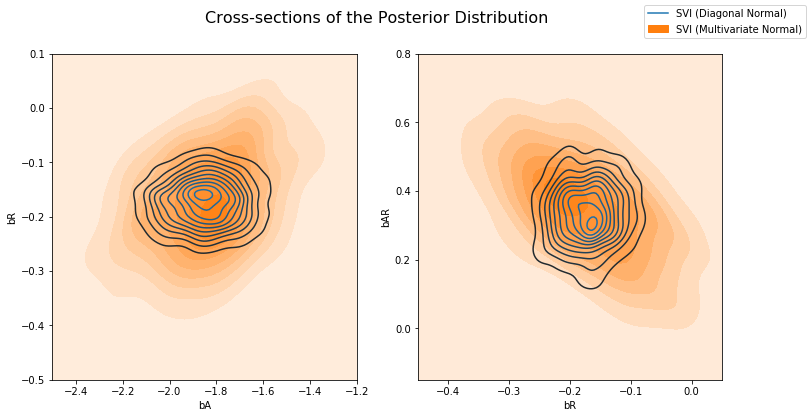

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(svi_samples["bA"], svi_samples["bR"], ax=axs[0], label="HMC")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], shade=True, label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(svi_samples["bR"], svi_samples["bAR"], ax=axs[1], label="SVI (Diagonal Normal)")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], shade=True, label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

and the Multivariate guide with the posterior computed by HMC.  Note that the Multivariate guide better captures the true posterior.

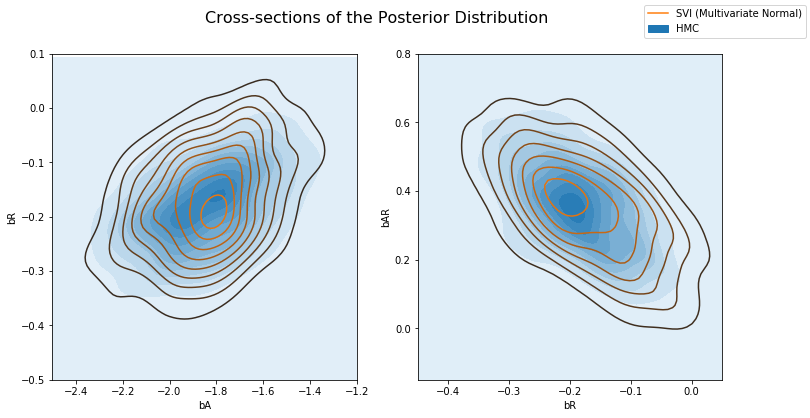

In [15]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))
fig.suptitle("Cross-sections of the Posterior Distribution", fontsize=16)
sns.kdeplot(hmc_samples["bA"], hmc_samples["bR"], ax=axs[0], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bA"], svi_mvn_samples["bR"], ax=axs[0], label="SVI (Multivariate Normal)")
axs[0].set(xlabel="bA", ylabel="bR", xlim=(-2.5, -1.2), ylim=(-0.5, 0.1))
sns.kdeplot(hmc_samples["bR"], hmc_samples["bAR"], ax=axs[1], shade=True, label="HMC")
sns.kdeplot(svi_mvn_samples["bR"], svi_mvn_samples["bAR"], ax=axs[1], label="SVI (Multivariate Normal)")
axs[1].set(xlabel="bR", ylabel="bAR", xlim=(-0.45, 0.05), ylim=(-0.15, 0.8))
handles, labels = axs[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right');

## References
[1] Yu and Meyer. [Multivariate Stochastic Volatility Models](https://pdfs.semanticscholar.org/fccc/6f4ee933d4330eabf377c08f8b2650e1f244.pdf). 2006.